### Electricity Usage Analytics

In [1]:
# Importing necessary module
import pandas as pd
import numpy as np
import matplotlib as mpl
from datetime import datetime
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import math
# from geopy.distance import geodesic
# import haversine as hs
import glob
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.preprocessing import MinMaxScaler

#### Loading dataset from property usage

In [2]:
#Loading datasets as one main dataframe
files=glob.glob('./input/*.csv')
df_list = []
for file in files:
    df_list.append(pd.read_csv(file, sep=','))
main_df = pd.concat(df_list, ignore_index=True)
main_df.to_csv("./data/main_dataset.csv",  index=False)
main_df = main_df.rename(columns={'READ DATE':'date','CONSUMPTION(KWH)':'consumption', 
                                  'SOLD TO GRID(KWH)':'sold'})
#Display first few rows
main_df.head()

,date,consumption,sold
0,01 August 2020,13.58,0.37
1,02 August 2020,12.39,0.25
2,03 August 2020,9.79,0.47
3,04 August 2020,16.77,0.26
4,05 August 2020,12.66,0.46


#### Data checking and preprocessing

In [3]:
#Checking datatypes of attributes
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         304 non-null    object
 1   consumption  304 non-null    object
 2   sold         304 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


In [4]:
# Check missing values
main_df.isnull().sum()

date           0
consumption    0
sold           0
dtype: int64

In [5]:
#Converting the 'date' column to datetime format
main_df['date']= pd.to_datetime(main_df['date'])
#Sorting data by date
main_df = main_df.sort_values(by='date')
#Removing non-numeric data 
main_df = main_df[main_df['consumption'] != 'Not available']
#Converting datatype of 'consumption' and 'sold' to float
main_df['consumption'] = pd.to_numeric(main_df['consumption'], downcast='float')
main_df['sold'] = pd.to_numeric(main_df['sold'], downcast='float')
#Checking datatypes of attributes
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 188 to 84
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         293 non-null    datetime64[ns]
 1   consumption  293 non-null    float32       
 2   sold         293 non-null    float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 6.9 KB


In [6]:
#Setting date to index
main_df = main_df.set_index('date')
main_df

,consumption,sold
date,,
2020-05-07,0.29,0.00
2020-05-08,0.34,0.00
2020-05-09,0.41,0.00
2020-05-10,0.52,0.00
2020-05-11,0.35,0.00
...,...,...
2021-02-19,3.66,11.73
2021-02-20,3.04,9.94
2021-02-21,2.54,3.54


In [7]:
#Adding columns for weekdays, month and year
main_df['Weekday'] = main_df.index.day_name()
main_df['Year'] = main_df.index.year
main_df['Month'] = main_df.index.month
main_df['Day'] = main_df.index.day
main_df['month'] = main_df['Month'].apply(lambda x: calendar.month_abbr[x])
#Display a random sampling of 5 rows
main_df.sample(5, random_state=0)

,consumption,sold,Weekday,Year,Month,Day,month
date,,,,,,,
2020-12-19,1.56,12.69,Saturday,2020,12,19,Dec
2021-02-16,2.90,12.64,Tuesday,2021,2,16,Feb
2020-12-02,2.56,15.90,Wednesday,2020,12,2,Dec
2020-10-25,15.95,0.88,Sunday,2020,10,25,Oct
2020-09-02,13.90,0.73,Wednesday,2020,9,2,Sep


#### Stacking data - Daily Global Solar Exposure (area: Beaconsfield Upper, Pakenham, Victoria, Australia)

In [8]:
s1 = pd.read_csv ('./input/2020/2020_Data.csv')
s2 = pd.read_csv ('./input/2021/2021_Data.csv')
solar_exp = pd.concat([s1, s2], ignore_index=True)
#Display a random sampling of 5 rows
solar_exp.sample(5, random_state=0)

,Product code,Bureau of Meteorology station number,Year,Month,Day,Daily global solar exposure (MJ/m*m)
15,IDCJAC0016,86261,2020,1,16,9.1
124,IDCJAC0016,86261,2020,5,4,6.3
141,IDCJAC0016,86261,2020,5,21,7.1
263,IDCJAC0016,86261,2020,9,20,18.2
170,IDCJAC0016,86261,2020,6,19,8.8


In [9]:
#Convert megajoule per square metre to kilowatt hour per square metre
solar_exp['daily_solar_exposure'] = solar_exp['Daily global solar exposure (MJ/m*m)']/3.6
#Display a random sampling of 5 rows
solar_exp.sample(5, random_state=0)

,Product code,Bureau of Meteorology station number,Year,Month,Day,Daily global solar exposure (MJ/m*m),daily_solar_exposure
15,IDCJAC0016,86261,2020,1,16,9.1,2.527778
124,IDCJAC0016,86261,2020,5,4,6.3,1.750000
141,IDCJAC0016,86261,2020,5,21,7.1,1.972222
263,IDCJAC0016,86261,2020,9,20,18.2,5.055556
170,IDCJAC0016,86261,2020,6,19,8.8,2.444444


In [10]:
#Keeping relevant columns 
solar_exp = solar_exp.drop(['Product code',
                            'Bureau of Meteorology station number',
                            'Daily global solar exposure (MJ/m*m)'], axis=1)
#Display first five 5 rows
solar_exp.head()

,Year,Month,Day,daily_solar_exposure
0,2020,1,1,8.777778
1,2020,1,2,8.722222
2,2020,1,3,8.361111
3,2020,1,4,5.611111
4,2020,1,5,1.527778


In [11]:
#Stacking data with main dataset
stack_df = main_df.merge(solar_exp, how = 'inner', on = ['Year', 'Month', 'Day']).set_index(main_df.index)
#Display a random sampling of 5 rows
stack_df.sample(5, random_state=0)

,consumption,sold,Weekday,Year,Month,Day,month,daily_solar_exposure
date,,,,,,,,
2020-12-19,1.56,12.69,Saturday,2020,12,19,Dec,5.000000
2021-02-16,2.90,12.64,Tuesday,2021,2,16,Feb,6.055556
2020-12-02,2.56,15.90,Wednesday,2020,12,2,Dec,6.722222
2020-10-25,15.95,0.88,Sunday,2020,10,25,Oct,4.250000
2020-09-02,13.90,0.73,Wednesday,2020,9,2,Sep,3.805556


In [12]:
#Scaling the data
scaler = MinMaxScaler()
stack_df['consumption'] = scaler.fit_transform(stack_df['consumption'].values.reshape(-1,1))
stack_df['sold'] = scaler.fit_transform(stack_df['sold'].values.reshape(-1,1))
stack_df['daily_solar_exposure'] = scaler.fit_transform(stack_df['daily_solar_exposure'].values.reshape(-1,1))
#Display a random sampling of 5 rows
stack_df.sample(5, random_state=0)

,consumption,sold,Weekday,Year,Month,Day,month,daily_solar_exposure
date,,,,,,,,
2020-12-19,0.054605,0.589684,Saturday,2020,12,19,Dec,0.541254
2021-02-16,0.109209,0.587361,Tuesday,2021,2,16,Feb,0.666667
2020-12-02,0.095355,0.738848,Wednesday,2020,12,2,Dec,0.745875
2020-10-25,0.640994,0.040892,Sunday,2020,10,25,Oct,0.452145
2020-09-02,0.557457,0.033922,Wednesday,2020,9,2,Sep,0.399340


#### Data Visualization

In [13]:
# #Checking if consumption ever goes to 0 
# print(stack_df[stack_df['consumption'] == 0.0])
# #Checking if sold ever goes to 0
# print(stack_df[stack_df['sold'] == 0.0].groupby(['month'], as_index=False)['sold'].count())

In [14]:
print ('Consumption in 10 months (in KWH): ',stack_df.consumption.sum())
print ('Output sold in 10 months (in KWH): ',stack_df.sold.sum())
a=stack_df.sold.sum()
b=stack_df.consumption.sum()
print ('Total output generated in 10 months (in KWH): ',(a+b))

Consumption in 10 months (in KWH):  69.43358
Output sold in 10 months (in KWH):  56.326202
Total output generated in 10 months (in KWH):  125.75978


<AxesSubplot:title={'center':'Monthly Energy Consumption'}, xlabel='month'>

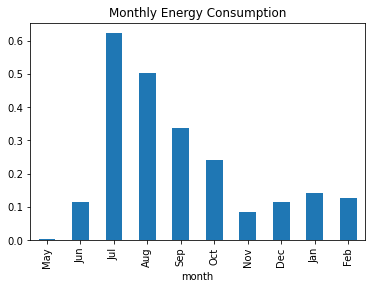

In [15]:
#Plotting monthly average 'consumption' 
stack_df.groupby('month')['consumption'].mean().reindex(['May','Jun','Jul','Aug','Sep','Oct',
                                                          'Nov','Dec','Jan','Feb']).plot.bar(title='Monthly Energy Consumption')

<AxesSubplot:title={'center':'Monthly Energy Sold'}, xlabel='month'>

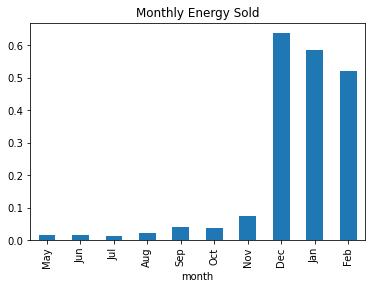

In [16]:
#Plotting monthly average 'sold' 
stack_df.groupby('month')['sold'].mean().reindex(['May','Jun','Jul','Aug','Sep','Oct',
                                                          'Nov','Dec','Jan','Feb']).plot.bar(title='Monthly Energy Sold')

<AxesSubplot:title={'center':'Monthly Avg Solar Exposure'}, xlabel='month'>

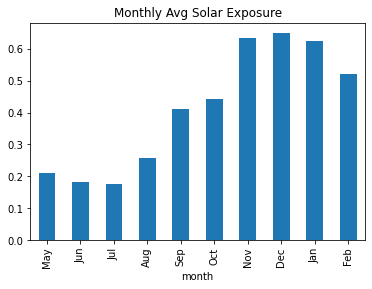

In [17]:
#Plotting monthly average 'daily_solar_exposure' 
stack_df.groupby('month')['daily_solar_exposure'].mean().reindex(['May','Jun','Jul','Aug','Sep','Oct',
                                                          'Nov','Dec','Jan','Feb']).plot.bar(title='Monthly Avg Solar Exposure')

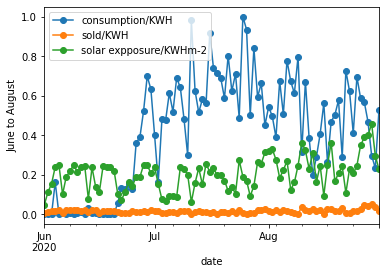

In [18]:
#Focusing on daily data from June to August
ax = stack_df.loc['2020-06':'2020-08', 'consumption'].plot(marker='o', linestyle='-', label='consumption/KWH')
ax = stack_df.loc['2020-06':'2020-08', 'sold'].plot(marker='o', linestyle='-', label='sold/KWH')
ax = stack_df.loc['2020-06':'2020-08', 'daily_solar_exposure'].plot(marker='o', linestyle='-', label='solar expposure/KWHm-2')
ax.set_ylabel('June to August');
plt.legend()

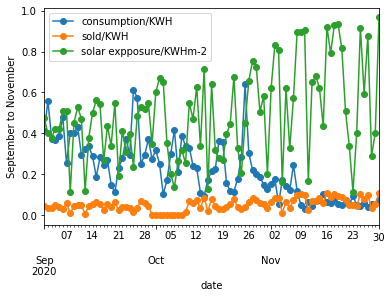

In [19]:
#Focusing on daily data from September to November
ax = stack_df.loc['2020-09':'2020-11', 'consumption'].plot(marker='o', linestyle='-', label='consumption/KWH')
ax = stack_df.loc['2020-09':'2020-11', 'sold'].plot(marker='o', linestyle='-', label='sold/KWH')
ax = stack_df.loc['2020-09':'2020-11', 'daily_solar_exposure'].plot(marker='o', linestyle='-', label='solar expposure/KWHm-2')
ax.set_ylabel('September to November');
plt.legend()

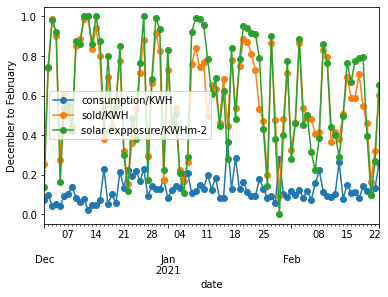

In [20]:
#Focusing on daily data from December to February
ax = stack_df.loc['2020-12':'2021-02', 'consumption'].plot(marker='o', linestyle='-', label='consumption/KWH')
ax = stack_df.loc['2020-12':'2021-02', 'sold'].plot(marker='o', linestyle='-', label='sold/KWH')
ax = stack_df.loc['2020-12':'2021-02', 'daily_solar_exposure'].plot(marker='o', linestyle='-', label='solar expposure/KWHm-2')
ax.set_ylabel('December to February');
plt.legend()

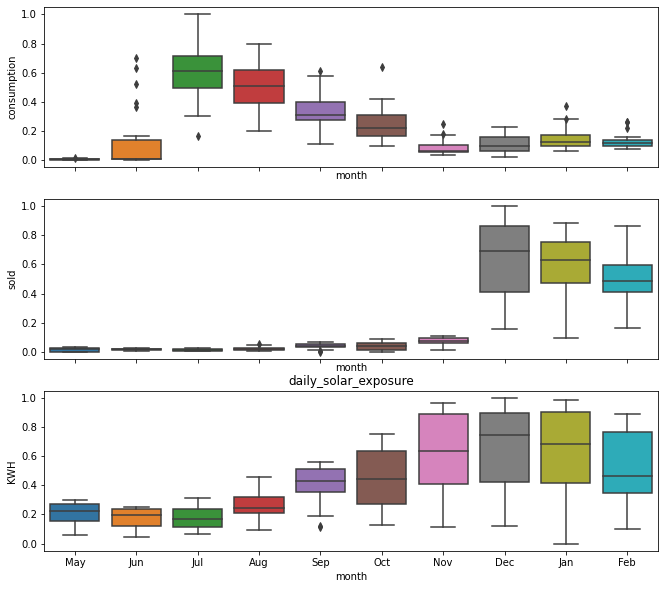

In [21]:
#Plotting boxplots of 'consumption' and 'sold' by month
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['consumption', 'sold', 'daily_solar_exposure'], axes):
    sns.boxplot(data=stack_df, x='month', y=name, ax=ax)
ax.set_ylabel('KWH')
ax.set_title(name)
# Removing the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

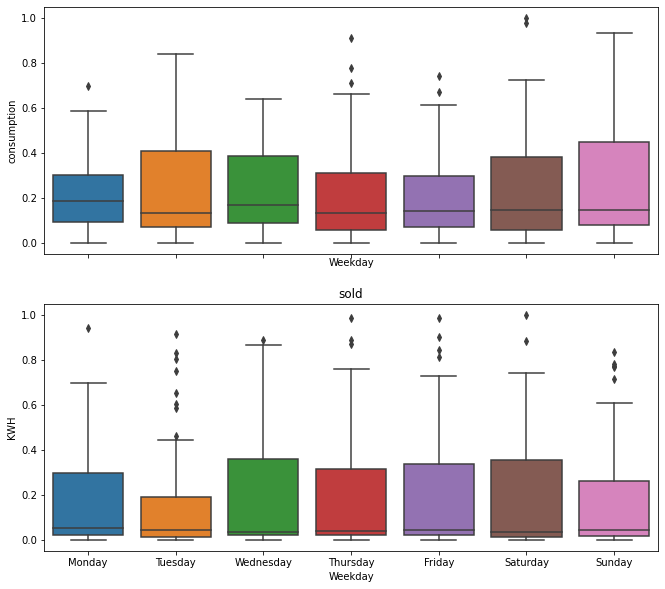

In [22]:
#Plotting boxplots of 'consumption' and 'sold' by month
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
my_order = order = ['Monday','Tuesday','Wednesday','Thursday',
                    'Friday','Saturday','Sunday']
for name, ax in zip(['consumption', 'sold'], axes):
    sns.boxplot(data=stack_df, x='Weekday', y=name, ax=ax, order = my_order)
ax.set_ylabel('KWH')
ax.set_title(name)
#Removing the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

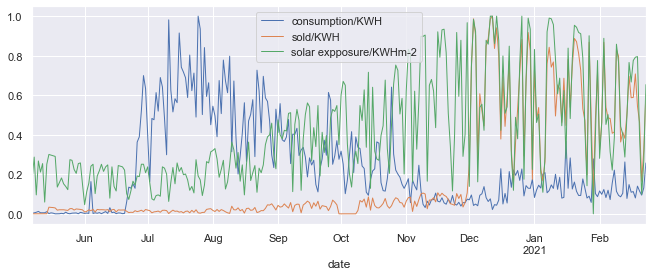

In [23]:
#Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
#Plotting daily 'consumption' 
stack_df['consumption'].plot(linewidth=1, label='consumption/KWH')
#Plotting daily 'sold' 
stack_df['sold'].plot(linewidth=1, label='sold/KWH')
#Plotting 'daily_solar_exposure' 
stack_df['daily_solar_exposure'].plot(linewidth=1, label='solar expposure/KWHm-2')
plt.legend()